# Variance Partitioning

In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression

from himalaya.backend import set_backend
from himalaya.kernel_ridge import KernelRidgeCV, MultipleKernelRidgeCV
from himalaya.kernel_ridge import Kernelizer
from himalaya.kernel_ridge import ColumnKernelizer

from sklearn.pipeline import make_pipeline
from sklearn import set_config

import matplotlib.pyplot as plt

from compare_variance_residual.simulated.simulation import generate_dataset

set_config(display='diagram')

In [2]:
backend = set_backend("cupy", on_error="warn")

## Generate a random dataset
- X_train : array of shape (n_samples_train, n_features)
- X_test : array of shape (n_samples_test, n_features)
- Y_train : array of shape (n_samples_train, n_targets)
- Y_test : array of shape (n_samples_test, n_targets)

In [22]:
unique_contributions = [0.3, 0.3]
n_features = len(unique_contributions)
n_features_list = [1000, 1000]
n_targets = 1000
n_samples_train = 1000
n_samples_test = 1000
noise = 0.0

# test uniform distribution
random_distribution = "uniform"

In [23]:
(Xs_train, Xs_test, Y_train, Y_test, n_features_list) = generate_dataset(
    n_features_list=n_features_list, n_targets=n_targets,
    n_samples_train=n_samples_train,
    n_samples_test=n_samples_test,
    noise=noise,
    unique_contributions=unique_contributions,
    random_distribution=random_distribution,
    random_state=42)

feature_names = [f"Feature space {ii}" for ii in range(len(n_features_list))]

# Variance Partitioning

## Single models

In [5]:
solver_params = dict()

single_pipelines = []
for feature in range(n_features):
    single_model = KernelRidgeCV(alphas=np.logspace(-10, 10, 41), kernel="precomputed", solver="eigenvalues",
                                 solver_params=solver_params)

    pipe = make_pipeline(Kernelizer(), single_model)
    single_pipelines.append(pipe)
    pipe.fit(Xs_train[feature], Y_train)

### Compute prediction scores

In [6]:
# predict for all targets
test_scores = []
for i, pipeline in enumerate(single_pipelines):
    score = pipeline.score(Xs_test[i], Y_test)
    score = backend.to_numpy(score)
    test_scores.append(score)

/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The KernelRidgeCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The KernelRidgeCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.Regress

 ### Plot voxelwise R^2 scores

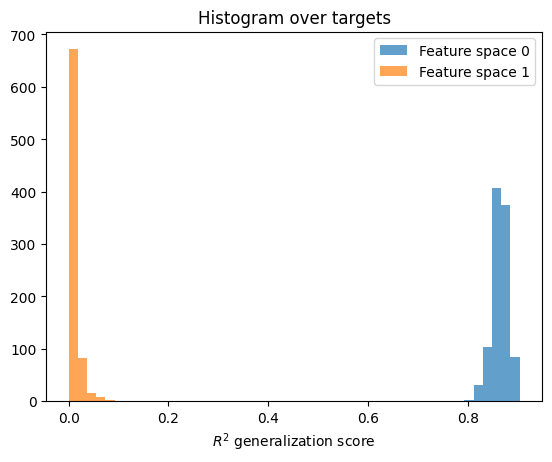

In [7]:
maximum = 0
for score in test_scores:
    maximum = max(maximum, score.max())

bins = np.linspace(0, maximum, 50)
for i, score in enumerate(test_scores):
    plt.hist(score, bins, alpha=0.7, label=f"{feature_names[i]}")

plt.xlabel(r"$R^2$ generalization score")
plt.title("Histogram over targets")
plt.legend()
plt.show()

## Joint model

In [8]:
X_train = np.hstack([X for X in Xs_train])
X_test = np.hstack([X for X in Xs_test])

### Prepare the pipeline

In [9]:
# Find the start and end of each feature space X in Xs
start_and_end = np.concatenate([[0], np.cumsum(n_features_list)])
slices = [
    slice(start, end)
    for start, end in zip(start_and_end[:-1], start_and_end[1:])
]

# Create a different ``Kernelizer`` for each feature space.
kernelizers = [("space %d" % ii, Kernelizer(), slice_)
               for ii, slice_ in enumerate(slices)]
column_kernelizer = ColumnKernelizer(kernelizers)

### Define the random-search model
We use very few iteration on purpose, to make the random search suboptimal,
and refine it with hyperparameter gradient descent.



In [10]:
solver_params = dict(n_iter=5, alphas=np.logspace(-10, 10, 41))

model_random = MultipleKernelRidgeCV(kernels="precomputed", solver="random_search",
                                     solver_params=solver_params, random_state=42)
pipe_random = make_pipeline(column_kernelizer, model_random)

# Fit the model on all targets
pipe_random.fit(X_train, Y_train)

[........................................] 100% | 1.54 sec | 5 random sampling with cv | 


/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The MultipleKernelRidgeCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Pipeline(steps=[('columnkernelizer',
                 ColumnKernelizer(transformers=[('space 0', Kernelizer(),
                                                 slice(np.int64(0), np.int64(1000), None)),
                                                ('space 1', Kernelizer(),
                                                 slice(np.int64(1000), np.int64(2000), None))])),
                ('multiplekernelridgecv',
                 MultipleKernelRidgeCV(kernels='precomputed', random_state=42,
                                       solver_params={'alphas': array([1.00000000e-10, 3.16227766e-10, 1.000...
       1.00000000e-02, 3.16227766e-02, 1.00000000e-01, 3.16227766e-01,
       1.00000000e+00, 3.16227766e+00, 1.00000000e+01, 3.16227766e+01,
       1.00000000e+02, 3.16227766e+02, 1.00000000e+03, 3.16227766e+03,
       1.00000000e+04, 3.16227766e+04, 1.00000000e+05, 3.16227766e+05,
       1.00000000e+06, 3.16227766e+06, 1.00000000e+07, 3.16227766e+07,
       1.00000000e+08, 3.16227766e+08, 1.00000000e+09, 3.16227766e+09,
       1.00000000e+10]),
                                                      'n_iter': 5}))])

### Define the gradient-descent model

In [11]:
solver_params = dict(max_iter=10, hyper_gradient_method="direct", max_iter_inner_hyper=10,
                     initial_deltas="here_will_go_the_previous_deltas")

model_gradient = MultipleKernelRidgeCV(kernels="precomputed", solver="hyper_gradient", solver_params=solver_params)
pipe_gradient = make_pipeline(column_kernelizer, model_gradient)

### Use the random-search to initialize the gradient-descent

In [12]:
pipe_gradient[-1].solver_params['initial_deltas'] = pipe_random[-1].deltas_
print(X_train.shape, Y_train.shape)
pipe_gradient.fit(X_train, Y_train)

(1000, 2000) (1000, 1000)
[........................................] 100% | 5.54 sec | hypergradient_direct | 


/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The MultipleKernelRidgeCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Pipeline(steps=[('columnkernelizer',
                 ColumnKernelizer(transformers=[('space 0', Kernelizer(),
                                                 slice(np.int64(0), np.int64(1000), None)),
                                                ('space 1', Kernelizer(),
                                                 slice(np.int64(1000), np.int64(2000), None))])),
                ('multiplekernelridgecv',
                 MultipleKernelRidgeCV(kernels='precomputed',
                                       solver='hyper_gradient',
                                       solver_params={'hyper_gradient_method': 'direct',
                                                      'initial_deltas': array([[  0.45334214,  22.3279    ,  -2.4279938 , ...,   1.609438  ,
         -1.8444397 ,  -2.3025851 ],
       [  0.46292555,  22.337484  ,  -4.440812  , ...,   1.609438  ,
         -1.8444397 , -36.045067  ]], shape=(2, 1000), dtype=float32),
                                                      'max_iter': 10,
                                                      'max_iter_inner_hyper': 10}))])

### Compute predictions on a test set

In [13]:
# use the first model for all targets
test_scores_random = pipe_random.score(X_test, Y_test)

# use the second model for the refined targets
test_scores_refined = pipe_gradient.score(X_test, Y_test)

test_scores_random = backend.to_numpy(test_scores_random)
test_scores_refined = backend.to_numpy(test_scores_refined)

/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The MultipleKernelRidgeCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The MultipleKernelRidgeCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `skle

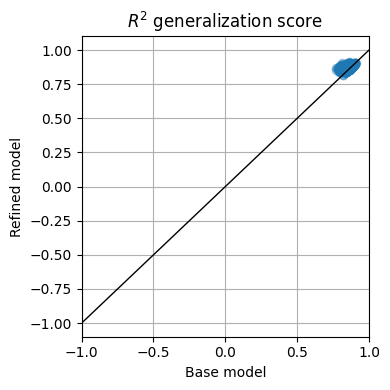

In [14]:
plt.figure(figsize=(4, 4))
plt.scatter(test_scores_random, test_scores_refined, alpha=0.3)
plt.xlim(-1, 1)
plt.plot(plt.xlim(), plt.xlim(), color='k', lw=1)
plt.xlabel(r"Base model")
plt.ylabel(r"Refined model")
plt.title("$R^2$ generalization score")
plt.grid()
plt.tight_layout()
plt.show()

## Model comparison

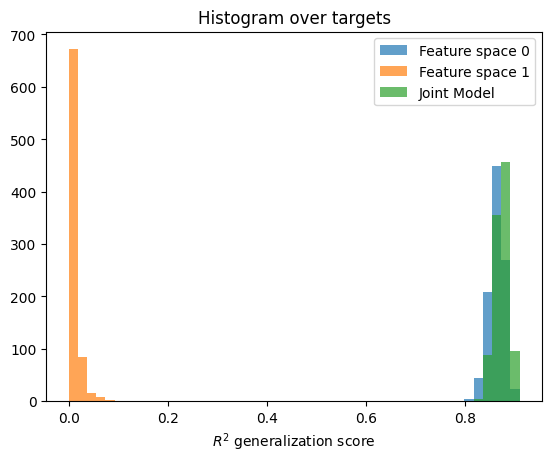

In [15]:
maximum = test_scores_refined.max()
for score in test_scores:
    maximum = max(maximum, score.max())

bins = np.linspace(0, maximum, 50)
for score, feature in zip(test_scores, feature_names):
    plt.hist(score, bins, alpha=0.7, label=feature)
plt.hist(test_scores_refined, bins, alpha=.7, label="Joint Model")

plt.xlabel(r"$R^2$ generalization score")
plt.title("Histogram over targets")
plt.legend()
plt.show()

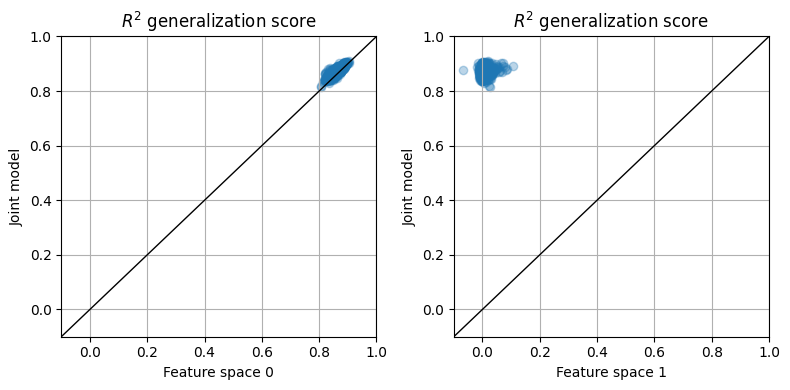

In [16]:
# Create a figure with subplots
fig, axs = plt.subplots(1, len(test_scores), figsize=(4 * len(test_scores), 4))

# Loop through each score and corresponding subplot
for i, score in enumerate(test_scores):
    ax = axs[i]
    ax.scatter(score, test_scores_refined, alpha=0.3)
    ax.set_xlim(-.1, 1)
    ax.set_ylim(-.1, 1)
    ax.plot(ax.get_xlim(), ax.get_xlim(), color='k', lw=1)
    ax.set_xlabel(f"{feature_names[i]}")
    ax.set_ylabel(r"Joint model")
    ax.set_title("$R^2$ generalization score")
    ax.grid()

# Adjust layout
plt.tight_layout()
plt.show()

## Variance partitioning

### Compute unique and shared variance using R^2

In [17]:
zero_minus_one = test_scores_refined - test_scores[1]
one_minus_zero = test_scores_refined - test_scores[0]

<>:11: SyntaxWarning: invalid escape sequence '\c'
<>:11: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_15984/94986095.py:11: SyntaxWarning: invalid escape sequence '\c'
  ax.set_ylabel(f"{feature_names[i]} \\ ({feature_names[0]}$\cap${feature_names[1]})")


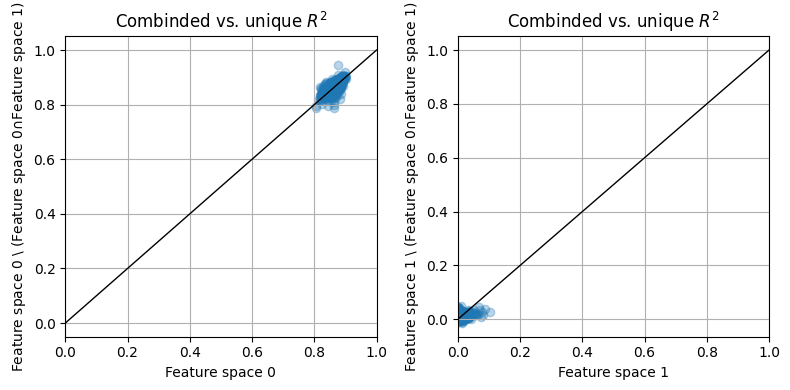

In [18]:
# Create a figure with subplots
fig, axs = plt.subplots(1, len(test_scores), figsize=(4 * len(test_scores), 4))

# Loop through each score and corresponding subplot
for i, (score, score_unique) in enumerate(zip(test_scores, [zero_minus_one, one_minus_zero])):
    ax = axs[i]
    ax.scatter(score, score_unique, alpha=0.3)
    ax.set_xlim(0, 1)
    ax.plot(ax.get_xlim(), ax.get_xlim(), color='k', lw=1)
    ax.set_xlabel(f"{feature_names[i]}")
    ax.set_ylabel(f"{feature_names[i]} \\ ({feature_names[0]}$\cap${feature_names[1]})")
    ax.set_title(r"Combinded vs. unique $R^2$")
    ax.grid()

# Adjust layout
plt.tight_layout()
plt.show()

As expected, most voxels have a lower coreration coefficient $\rho$, but some have higher correlation scores, than before

In [19]:
float(unique_contributions[0] - zero_minus_one.mean())

-0.06790369749069214

# Residual method

Train a model to map from $X_1$ to $X_0$

## Train model

In [38]:
model = KernelRidgeCV(alphas=np.logspace(-10, 10, 41), kernel="linear", solver="eigenvalues")
model.fit(Xs_train[1], Xs_train[0])

/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The KernelRidgeCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


KernelRidgeCV(alphas=array([1.00000000e-10, 3.16227766e-10, 1.00000000e-09, 3.16227766e-09,
       1.00000000e-08, 3.16227766e-08, 1.00000000e-07, 3.16227766e-07,
       1.00000000e-06, 3.16227766e-06, 1.00000000e-05, 3.16227766e-05,
       1.00000000e-04, 3.16227766e-04, 1.00000000e-03, 3.16227766e-03,
       1.00000000e-02, 3.16227766e-02, 1.00000000e-01, 3.16227766e-01,
       1.00000000e+00, 3.16227766e+00, 1.00000000e+01, 3.16227766e+01,
       1.00000000e+02, 3.16227766e+02, 1.00000000e+03, 3.16227766e+03,
       1.00000000e+04, 3.16227766e+04, 1.00000000e+05, 3.16227766e+05,
       1.00000000e+06, 3.16227766e+06, 1.00000000e+07, 3.16227766e+07,
       1.00000000e+08, 3.16227766e+08, 1.00000000e+09, 3.16227766e+09,
       1.00000000e+10]))

In [41]:
train_predict = model.predict(Xs_train[1])
test_predict = model.predict(Xs_test[1])
train_predict, test_predict = backend.asarray(train_predict), backend.asarray(test_predict)

/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The KernelRidgeCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The KernelRidgeCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.Regress

## Compute residuals and train new model on residuals

In [42]:
train_residual = Xs_train[0] - train_predict
test_residual = Xs_test[0] - test_predict

### Ridge mapping

In [43]:
model_residual = KernelRidgeCV(alphas=np.logspace(-10, 10, 41), kernel="linear")
model_residual.fit(train_residual, Y_train)

/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The KernelRidgeCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


KernelRidgeCV(alphas=array([1.00000000e-10, 3.16227766e-10, 1.00000000e-09, 3.16227766e-09,
       1.00000000e-08, 3.16227766e-08, 1.00000000e-07, 3.16227766e-07,
       1.00000000e-06, 3.16227766e-06, 1.00000000e-05, 3.16227766e-05,
       1.00000000e-04, 3.16227766e-04, 1.00000000e-03, 3.16227766e-03,
       1.00000000e-02, 3.16227766e-02, 1.00000000e-01, 3.16227766e-01,
       1.00000000e+00, 3.16227766e+00, 1.00000000e+01, 3.16227766e+01,
       1.00000000e+02, 3.16227766e+02, 1.00000000e+03, 3.16227766e+03,
       1.00000000e+04, 3.16227766e+04, 1.00000000e+05, 3.16227766e+05,
       1.00000000e+06, 3.16227766e+06, 1.00000000e+07, 3.16227766e+07,
       1.00000000e+08, 3.16227766e+08, 1.00000000e+09, 3.16227766e+09,
       1.00000000e+10]))

#### Compute predictions

In [44]:
score = model_residual.score(test_residual, Y_test)
score = backend.to_numpy(score)
mean = np.mean(score)
print(mean)

float(unique_contributions[0] - mean)

0.22539188


0.07460813224315643